In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import math
import random

import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multicomp import MultiComparison

In [3]:
from dcstats.rantest import RantestContinuous
from dcstats.basic_stats import TTestContinuous
from dcstats.Hedges import Hedges_d

In [53]:
class RantestContinuous():
    def __init__(self, X, Y, are_paired=False):
        """ 
        Parameters
        ----------
        X : observations in first trial, list of floats
        Y : observations in second trial, list of floats
        are_paired : are observations paired, boolean
        """   
        self.X, self.Y = X, Y
        self.nx, self.ny = len(X), len(Y)
        self.are_paired = are_paired
        random.seed(1984)
        np.random.seed(1984)
            
    def run_rantest(self, nran):
        self.nran = nran
        self.randiff = np.zeros(nran)
        
        if self.are_paired:
            self.D = np.array(self.X) - np.array(self.Y)
            self.dbar = np.mean(self.D)
            for i in range(nran):
                ones = np.ones(self.nx)
                ones[np.random.random(self.nx) < 0.5] *= -1             
                self.randiff[i] = np.sum(self.D * ones) / float(self.nx)    # mean difference

        else:    # if not paired
            self.dbar = np.mean(self.X) - np.mean(self.Y)
            allobs = np.concatenate([self.X, self.Y])
            for i in range(0, nran):
                random.shuffle(allobs)
                sy = sum(allobs[self.nx : ])
                self.randiff[i] = (sum(allobs) - sy) / float(self.nx) - sy / float(self.ny)
                
        self.na1 = self.randiff[np.fabs(self.randiff) >= math.fabs(self.dbar)].size        
        self.ne2 = self.randiff[np.fabs(self.randiff) == math.fabs(self.dbar)].size        
        self.ng1 = self.randiff[self.randiff >= self.dbar].size
        self.ne1 = self.randiff[self.randiff == self.dbar].size
        self.nl1 = self.randiff[self.randiff <= self.dbar].size
        
    def __repr__(self):
        return ('\n\n   Rantest:  {0:d} randomisations'.format(self.nran) +
        '\n P values for difference between means ' +
        '\n  greater than or equal to observed: P = \t {0:.6f}'.format(self.ng1 / float(self.nran)) +
        '\n  less than or equal to observed: P = \t {0:.6f}'.format(self.nl1 / float(self.nran)) +
        '\n  greater than or equal in absolute value to observed: P = \t {0:.6f}'.format(self.na1 / float(self.nran)) +
        '\n  Number equal to observed = {0:d} (P= {1:.6f})'.format(self.ne1, self.ne1 / float(self.nran)) +
        '\n  Number equal in absolute value to observed = {0:d} (P= {1:.6f})'.format(self.ne2, self.ne2 / float(self.nran)))


In [5]:
def stack_for_tukey(df):
    """ Stack the data (and rename columns)"""
    stacked_data = df.stack().reset_index()
    #print(stacked_data.head())
    stacked_data = stacked_data.rename(columns={'level_0': 'id',
                                                'level_1': 'condition',
                                                0:'result'})
    #print (stacked_data.head())
    return stacked_data

def tukey_summary_and_plot(stack, k):
    # Set up the data for comparison (creates a specialised object)
    multi_comp = MultiComparison(stack['result'],
                                 stack['condition'])
    # Show all pair-wise comparisons:
    print(multi_comp.tukeyhsd().summary())
    if k > 2:
        multi_comp.tukeyhsd().plot_simultaneous();    # Plot group confidence intervals

In [6]:
xl = pd.ExcelFile("analysis/for_stats_S270T.xlsx")
xl.sheet_names

['EC50',
 'maxPopen',
 'sc_amplitudes',
 'Irel',
 'jump_peak',
 'jump_rise',
 'jump_deact']

### EC50

In [7]:
ec50 = xl.parse("EC50")
ec50.head()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg,a1WTs,a1S270Ts
0,0.343219,0.234146,1.410882,0.805278,21.02460,24.771213
1,0.253451,0.204491,0.770479,0.915122,22.41770,27.961486
2,0.207938,0.233946,0.782033,0.877297,9.87337,22.496041
3,0.233913,0.215334,1.064370,0.905444,6.56812,20.272358
4,0.241670,0.278040,1.365474,0.781964,13.21850,21.435463


In [8]:
ec50.describe()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg,a1WTs,a1S270Ts
count,10.000000,5.000000,8.000000,8.000000,7.000000,6.000000
mean,0.235812,0.233192,1.084261,0.851993,14.236884,23.308177
std,0.060119,0.028087,0.257108,0.114950,5.844527,2.732513
min,0.164993,0.204491,0.770479,0.617295,6.568120,20.272358
25%,0.199629,0.215334,0.865373,0.799450,10.391085,21.700607
50%,0.228749,0.233946,1.071845,0.891370,13.218500,22.704271
75%,0.250505,0.234146,1.322652,0.920274,18.335850,24.306535
max,0.343219,0.278040,1.410882,0.977815,22.417700,27.961486


In [9]:
# scipy independent t-test
stats.ttest_ind(ec50["a1WTg"], ec50["a1S270Tg"], equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=-9.13604108662284, pvalue=2.282558976237772e-05)

In [10]:
# DCstats t-test
TTestContinuous(ec50["a1WTg"].dropna(), ec50["a1S270Tg"].dropna(), are_paired=False)

n 		 10      	  8
Mean 		 0.235812    	  1.084261
SD 		 0.060119     	  0.257108
SDM 		 0.019011     	  0.090902
95% confidence intervals:
lower 		 0.198550    	  0.906094
upper 		 0.273075    	  1.262428

 Two-sample unpaired Students t-test:
 t = 	 -9.136041
 two tail P = 	 9.510E-08

In [63]:
hedges = Hedges_d(ec50["a1WTg"].dropna(), ec50["a1S270Tg"].dropna())
hedges.hedges_d_unbiased()
print('Effect size: Hedges unbiased d =', hedges.d)

Effect size: Hedges unbiased d = 4.5928130703830226


In [54]:
nran = 50000
rnt = RantestContinuous(ec50["a1WTg"].dropna(), ec50["a1S270Tg"].dropna(), are_paired=False)    
rnt.run_rantest(nran)
print(rnt)



   Rantest:  50000 randomisations
 P values for difference between means 
  greater than or equal to observed: P = 	 1.000000
  less than or equal to observed: P = 	 0.000000
  greater than or equal in absolute value to observed: P = 	 0.000000
  Number equal to observed = 0 (P= 0.000000)
  Number equal in absolute value to observed = 0 (P= 0.000000)


In [11]:
TTestContinuous(ec50["a1WTs"].dropna(), ec50["a1S270Ts"].dropna(), are_paired=False)

n 		 7      	  6
Mean 		 14.236884    	  23.308177
SD 		 5.844527     	  2.732513
SDM 		 2.209024     	  1.115544
95% confidence intervals:
lower 		 9.907198    	  21.121711
upper 		 18.566571    	  25.494642

 Two-sample unpaired Students t-test:
 t = 	 -3.665588
 two tail P = 	 3.718E-03

In [64]:
hedges = Hedges_d(ec50["a1WTs"].dropna(), ec50["a1S270Ts"].dropna())
hedges.hedges_d_unbiased()
print('Effect size: Hedges unbiased d =', hedges.d)

Effect size: Hedges unbiased d = 1.7980201964190816


In [51]:
nran = 50000
rnt = RantestContinuous(ec50["a1WTs"].dropna(), ec50["a1S270Ts"].dropna(), are_paired=False)    
rnt.run_rantest(nran)
print(rnt)



   Rantest:  50000 randomisations
 P values for difference between means 
  greater than or equal to observed: P = 	 0.996440
  less than or equal to observed: P = 	 0.003560
  greater than or equal in absolute value to observed: P = 	 0.007620
  Number equal to observed = 0 (P= 0.000000)
  Number equal in absolute value to observed = 0 (P= 0.000000)


In [12]:
stats.f_oneway(ec50['a1WTg'].dropna(), 
               ec50['a1bWTg'].dropna(), 
               ec50['a1S270Tg'].dropna(), 
               ec50['a1bS270Tg'].dropna(),
               ec50['a1WTs'].dropna(), 
               ec50['a1S270Ts'].dropna()
              )

F_onewayResult(statistic=99.3687212170434, pvalue=9.332016858407185e-21)

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper   reject
-----------------------------------------------------
 a1S270Tg  a1S270Ts 22.2239  18.1279  26.3199   True 
 a1S270Tg   a1WTg   -0.8484   -4.446   2.7491  False 
 a1S270Tg   a1WTs   13.1526   9.2273  17.0779   True 
 a1S270Tg a1bS270Tg -0.2323  -4.0245   3.5599  False 
 a1S270Tg   a1bWTg  -0.8511  -5.1748   3.4727  False 
 a1S270Ts   a1WTg   -23.0724 -26.9889 -19.1558  True 
 a1S270Ts   a1WTs   -9.0713  -13.2908 -4.8517   True 
 a1S270Ts a1bS270Tg -22.4562 -26.5522 -18.3602  True 
 a1S270Ts   a1bWTg  -23.075  -27.6676 -18.4824  True 
  a1WTg     a1WTs   14.0011  10.2635  17.7387   True 
  a1WTg   a1bS270Tg  0.6162  -2.9814   4.2138  False 
  a1WTg     a1bWTg  -0.0026  -4.1568   4.1515  False 
  a1WTs   a1bS270Tg -13.3849 -17.3102 -9.4596   True 
  a1WTs     a1bWTg  -14.0037 -18.4446 -9.5627   True 
a1bS270Tg   a1bWTg  -0.6188  -4.9426   3.705   False 
----------------------------

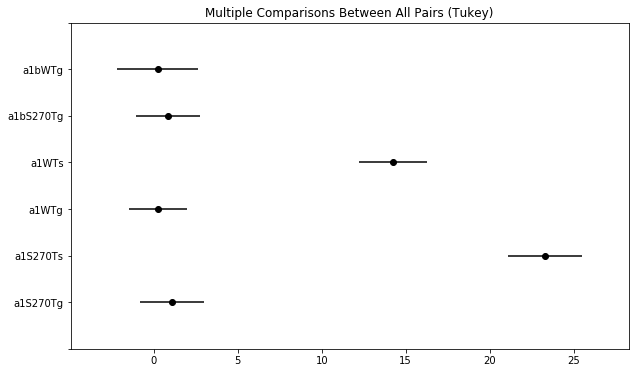

In [13]:
tukey_summary_and_plot(stack_for_tukey(ec50), ec50.shape[1])

### Relative current

In [15]:
Irel = xl.parse("Irel")
Irel.head()

,a1WTs,a1S270Ts
0,0.403844,0.127884
1,0.495664,0.098185
2,0.597923,0.098890
3,0.637583,0.028487
4,0.288995,0.030032


In [16]:
Irel.describe()

,a1WTs,a1S270Ts
count,11.000000,7.000000
mean,0.597643,0.084286
std,0.232022,0.041529
min,0.288995,0.028487
25%,0.408780,0.054078
50%,0.597923,0.098185
75%,0.786868,0.113387
max,0.919380,0.128398


In [17]:
# DCstats t-test
TTestContinuous(Irel["a1WTs"].dropna(), Irel["a1S270Ts"].dropna(), are_paired=False)

n 		 11      	  7
Mean 		 0.597643    	  0.084286
SD 		 0.232022     	  0.041529
SDM 		 0.069957     	  0.015697
95% confidence intervals:
lower 		 0.460526    	  0.053520
upper 		 0.734759    	  0.115051

 Two-sample unpaired Students t-test:
 t = 	 7.160120
 two tail P = 	 2.266E-06

In [18]:
stats.f_oneway(Irel['a1WTs'].dropna(), 
               Irel['a1S270Ts'].dropna()
              )

F_onewayResult(statistic=32.87371445394882, pvalue=3.0793497669082805e-05)

In [19]:
tukey_summary_and_plot(stack_for_tukey(Irel), 2)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff lower  upper  reject
---------------------------------------------
a1S270Ts a1WTs   0.5134  0.3236 0.7032  True 
---------------------------------------------


### maxPopen

In [20]:
mPop = xl.parse("maxPopen")
mPop.head()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg
0,0.997,0.988230,0.137347,0.8900
1,0.997,0.991865,0.244816,0.9965
2,0.997,0.994455,0.121860,0.9400
3,0.994,0.993009,0.220632,0.9700
4,0.986,0.996482,0.182138,0.9600


In [21]:
mPop.describe()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg
count,45.000000,87.000000,128.000000,131.000000
mean,0.987067,0.993191,0.156523,0.964477
std,0.017705,0.005898,0.141228,0.027874
min,0.900000,0.964864,0.005038,0.850000
25%,0.987000,0.992267,0.067556,0.950000
50%,0.993000,0.994582,0.120919,0.970000
75%,0.997000,0.996703,0.193648,0.980000
max,0.999000,0.999531,0.826069,1.000000


In [22]:
# DCstats t-test
TTestContinuous(mPop["a1WTg"].dropna(), mPop["a1bWTg"].dropna(), are_paired=False)

n 		 45      	  87
Mean 		 0.987067    	  0.993191
SD 		 0.017705     	  0.005898
SDM 		 0.002639     	  0.000632
95% confidence intervals:
lower 		 0.981894    	  0.991952
upper 		 0.992240    	  0.994431

 Two-sample unpaired Students t-test:
 t = 	 -2.256697
 two tail P = 	 2.570E-02

In [65]:
hedges = Hedges_d(mPop["a1WTg"].dropna(), mPop["a1bWTg"].dropna())
hedges.hedges_d_unbiased()
print('Effect size: Hedges unbiased d =', hedges.d)

Effect size: Hedges unbiased d = 0.5358988365019389


In [57]:
nran = 50000
rnt = RantestContinuous(mPop["a1WTg"].dropna(), mPop["a1bWTg"].dropna(), are_paired=False)    
rnt.run_rantest(nran)
print(rnt)



   Rantest:  50000 randomisations
 P values for difference between means 
  greater than or equal to observed: P = 	 0.998240
  less than or equal to observed: P = 	 0.001760
  greater than or equal in absolute value to observed: P = 	 0.001780
  Number equal to observed = 0 (P= 0.000000)
  Number equal in absolute value to observed = 0 (P= 0.000000)


In [23]:
# DCstats t-test
TTestContinuous(mPop["a1WTg"].dropna(), mPop["a1S270Tg"].dropna(), are_paired=False)

n 		 45      	  128
Mean 		 0.987067    	  0.156523
SD 		 0.017705     	  0.141228
SDM 		 0.002639     	  0.012483
95% confidence intervals:
lower 		 0.981894    	  0.132057
upper 		 0.992240    	  0.180990

 Two-sample unpaired Students t-test:
 t = 	 65.095228
 two tail P = 	 1.344E-122

In [24]:
# DCstats t-test
TTestContinuous(mPop["a1S270Tg"].dropna(), mPop["a1bS270Tg"].dropna(), are_paired=False)

n 		 128      	  131
Mean 		 0.156523    	  0.964477
SD 		 0.141228     	  0.027874
SDM 		 0.012483     	  0.002435
95% confidence intervals:
lower 		 0.132057    	  0.959704
upper 		 0.180990    	  0.969250

 Two-sample unpaired Students t-test:
 t = 	 -63.526999
 two tail P = 	 3.808E-159

In [25]:
# DCstats t-test
TTestContinuous(mPop["a1bWTg"].dropna(), mPop["a1bS270Tg"].dropna(), are_paired=False)

n 		 87      	  131
Mean 		 0.993191    	  0.964477
SD 		 0.005898     	  0.027874
SDM 		 0.000632     	  0.002435
95% confidence intervals:
lower 		 0.991952    	  0.959704
upper 		 0.994431    	  0.969250

 Two-sample unpaired Students t-test:
 t = 	 11.412019
 two tail P = 	 6.491E-24

In [26]:
stats.f_oneway(mPop['a1WTg'].dropna(), 
               mPop['a1bWTg'].dropna(), 
               mPop['a1S270Tg'].dropna(), 
               mPop['a1bS270Tg'].dropna(),
              )

F_onewayResult(statistic=2828.5990754751997, pvalue=9.106610245864995e-263)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
 a1S270Tg   a1WTg    0.8305   0.7935 0.8676  True 
 a1S270Tg a1bS270Tg  0.808    0.7814 0.8345  True 
 a1S270Tg   a1bWTg   0.8367   0.807  0.8663  True 
  a1WTg   a1bS270Tg -0.0226  -0.0595 0.0143 False 
  a1WTg     a1bWTg   0.0061  -0.0331 0.0453 False 
a1bS270Tg   a1bWTg   0.0287  -0.0008 0.0582 False 
--------------------------------------------------


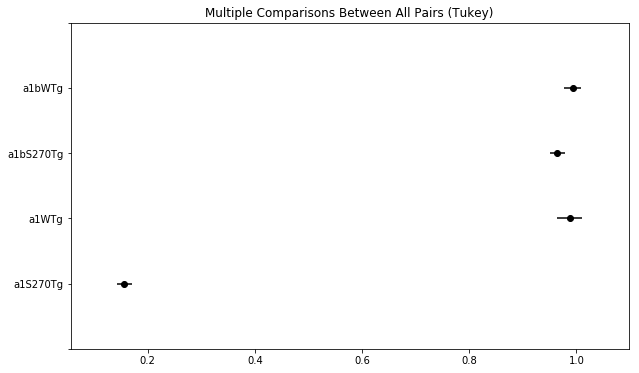

In [27]:
tukey_summary_and_plot(stack_for_tukey(mPop), mPop.shape[1])

### Single channel amplitudes

In [28]:
amp = xl.parse("sc_amplitudes")
amp.head()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg
0,5.57,2.292788,5.331562,1.91
1,5.62,2.269318,5.067471,2.23
2,5.19,2.681124,5.102301,2.12
3,5.49,2.462000,4.968930,2.37
4,4.62,2.452268,5.183255,2.35


In [29]:
amp.describe()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg
count,45.000000,87.000000,128.000000,131.000000
mean,5.550222,2.537316,4.409221,2.942901
std,0.469712,0.220310,0.784886,0.632665
min,3.910000,1.968898,2.610942,1.910000
25%,5.400000,2.402617,3.789110,2.390000
50%,5.620000,2.514087,4.258565,2.720000
75%,5.810000,2.649561,5.159386,3.625000
max,6.210000,3.367562,5.679758,4.140000


In [30]:
# DCstats t-test
TTestContinuous(amp["a1WTg"].dropna(), amp["a1bWTg"].dropna(), are_paired=False)

n 		 45      	  87
Mean 		 5.550222    	  2.537316
SD 		 0.469712     	  0.220310
SDM 		 0.070021     	  0.023620
95% confidence intervals:
lower 		 5.412982    	  2.491022
upper 		 5.687463    	  2.583611

 Two-sample unpaired Students t-test:
 t = 	 40.771696
 two tail P = 	 6.228E-76

In [31]:
# DCstats t-test
TTestContinuous(amp["a1WTg"].dropna(), amp["a1S270Tg"].dropna(), are_paired=False)

n 		 45      	  128
Mean 		 5.550222    	  4.409221
SD 		 0.469712     	  0.784886
SDM 		 0.070021     	  0.069375
95% confidence intervals:
lower 		 5.412982    	  4.273247
upper 		 5.687463    	  4.545196

 Two-sample unpaired Students t-test:
 t = 	 11.575725
 two tail P = 	 2.979E-23

In [32]:
# DCstats t-test
TTestContinuous(amp["a1bWTg"].dropna(), amp["a1bS270Tg"].dropna(), are_paired=False)

n 		 87      	  131
Mean 		 2.537316    	  2.942901
SD 		 0.220310     	  0.632665
SDM 		 0.023620     	  0.055276
95% confidence intervals:
lower 		 2.491022    	  2.834559
upper 		 2.583611    	  3.051242

 Two-sample unpaired Students t-test:
 t = 	 -6.747245
 two tail P = 	 1.363E-10

In [33]:
stats.f_oneway(amp['a1WTg'].dropna(), 
               amp['a1bWTg'].dropna(), 
               amp['a1S270Tg'].dropna(), 
               amp['a1bS270Tg'].dropna(),
              )

F_onewayResult(statistic=366.32911498669176, pvalue=1.1712913435866456e-112)

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
 a1S270Tg   a1WTg    1.141    0.8681  1.4139  True 
 a1S270Tg a1bS270Tg -1.4663   -1.662 -1.2706  True 
 a1S270Tg   a1bWTg  -1.8719  -2.0907 -1.6531  True 
  a1WTg   a1bS270Tg -2.6073  -2.8794 -2.3352  True 
  a1WTg     a1bWTg  -3.0129  -3.3021 -2.7237  True 
a1bS270Tg   a1bWTg  -0.4056  -0.6234 -0.1878  True 
---------------------------------------------------


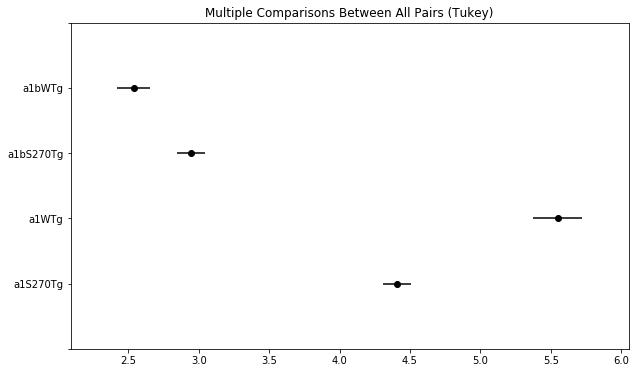

In [34]:
tukey_summary_and_plot(stack_for_tukey(amp), amp.shape[1])

### Jumps

In [35]:
jpeak = xl.parse("jump_peak")
jpeak.head()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg
0,768.0,151.0,98.8,32.5
1,2691.0,25.4,43.5,125.0
2,7563.0,69.4,81.5,567.0
3,2662.0,228.0,13.4,95.5
4,10784.0,64.5,36.4,326.0


In [36]:
jpeak.describe()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg
count,6.000000,5.000000,6.000000,7.000000
mean,4945.500000,107.660000,54.616667,175.657143
std,3708.244261,81.322494,31.078572,200.805975
min,768.000000,25.400000,13.400000,21.000000
25%,2669.250000,64.500000,38.175000,47.550000
50%,3948.000000,69.400000,48.800000,95.500000
75%,6973.500000,151.000000,74.650000,225.500000
max,10784.000000,228.000000,98.800000,567.000000


##### Jump activation

In [37]:
jrise = xl.parse("jump_rise")
jrise.head()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg
0,0.144,0.196,0.211,0.196
1,0.214,0.122,0.281,0.173
2,0.094,0.390,0.286,0.195
3,0.123,0.161,0.359,0.149
4,0.103,0.268,0.613,0.158


In [38]:
jrise.describe()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg
count,6.000000,5.000000,6.000000,7.000000
mean,0.130106,0.227400,0.355667,0.182429
std,0.044888,0.105583,0.140279,0.025690
min,0.094000,0.122000,0.211000,0.149000
25%,0.102728,0.161000,0.282250,0.165500
50%,0.113000,0.196000,0.322500,0.181000
75%,0.138750,0.268000,0.377750,0.195500
max,0.214000,0.390000,0.613000,0.225000


In [39]:
# DCstats t-test
TTestContinuous(jrise["a1WTg"].dropna(), jrise["a1bWTg"].dropna(), are_paired=False)

n 		 6      	  5
Mean 		 0.130106    	  0.227400
SD 		 0.044888     	  0.105583
SDM 		 0.018325     	  0.047218
95% confidence intervals:
lower 		 0.094188    	  0.134852
upper 		 0.166024    	  0.319948

 Two-sample unpaired Students t-test:
 t = 	 -1.920920
 two tail P = 	 8.693E-02

In [40]:
stats.f_oneway(jrise['a1WTg'].dropna(), 
               jrise['a1bWTg'].dropna(), 
               jrise['a1S270Tg'].dropna(), 
               jrise['a1bS270Tg'].dropna(),
              )

F_onewayResult(statistic=7.174369140914456, pvalue=0.001863266577636503)

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
 a1S270Tg   a1WTg   -0.2256  -0.3687 -0.0824  True 
 a1S270Tg a1bS270Tg -0.1732  -0.3112 -0.0353  True 
 a1S270Tg   a1bWTg  -0.1283  -0.2784  0.0219 False 
  a1WTg   a1bS270Tg  0.0523  -0.0857  0.1903 False 
  a1WTg     a1bWTg   0.0973  -0.0529  0.2475 False 
a1bS270Tg   a1bWTg   0.045   -0.1002  0.1902 False 
---------------------------------------------------


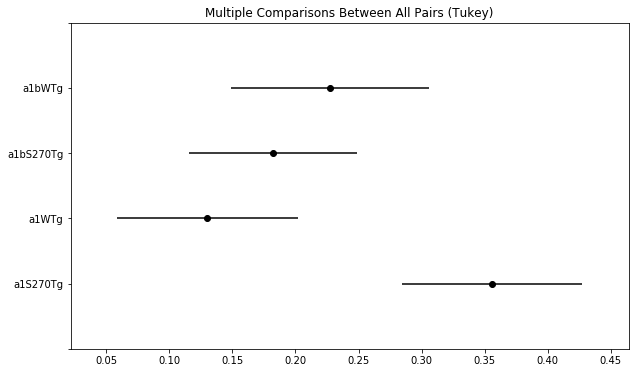

In [41]:
tukey_summary_and_plot(stack_for_tukey(jrise), jrise.shape[1])

##### Jump deactivation

In [42]:
jdeact = xl.parse("jump_deact")
jdeact.head()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg
0,18.9000,14.50,1.640,1.580
1,10.5000,17.80,1.080,2.640
2,8.7600,7.09,0.733,1.730
3,8.2065,6.20,1.201,0.937
4,17.6360,3.88,0.944,1.499


In [43]:
jdeact.describe()

,a1WTg,a1bWTg,a1S270Tg,a1bS270Tg
count,6.000000,5.000000,6.000000,7.000000
mean,12.053408,9.894000,1.181333,1.540143
std,4.900064,5.945509,0.338714,0.557482
min,8.206500,3.880000,0.733000,0.937000
25%,8.428463,6.200000,0.978000,1.197500
50%,9.630000,7.090000,1.140500,1.499000
75%,15.852000,14.500000,1.417750,1.655000
max,18.900000,17.800000,1.640000,2.640000


In [44]:
# DCstats t-test
TTestContinuous(jdeact["a1WTg"].dropna(), jdeact["a1bWTg"].dropna(), are_paired=False)

n 		 6      	  5
Mean 		 12.053408    	  9.894000
SD 		 4.900064     	  5.945509
SDM 		 2.000443     	  2.658913
95% confidence intervals:
lower 		 8.132541    	  4.682531
upper 		 15.974276    	  15.105469

 Two-sample unpaired Students t-test:
 t = 	 0.648978
 two tail P = 	 5.326E-01

In [45]:
# DCstats t-test
TTestContinuous(jdeact["a1WTg"].dropna(), jdeact["a1S270Tg"].dropna(), are_paired=False)

n 		 6      	  6
Mean 		 12.053408    	  1.181333
SD 		 4.900064     	  0.338714
SDM 		 2.000443     	  0.138279
95% confidence intervals:
lower 		 8.132541    	  0.910306
upper 		 15.974276    	  1.452361

 Mean difference (dbar) = 	 10.872075
  s(d) = 	 4.820486 	 s(dbar) = 	 1.967955

 Two-sample unpaired Students t-test:
 t = 	 5.421897
 two tail P = 	 2.922E-04

In [46]:
# DCstats t-test
TTestContinuous(jdeact["a1bWTg"].dropna(), jdeact["a1bS270Tg"].dropna(), are_paired=False)

n 		 5      	  7
Mean 		 9.894000    	  1.540143
SD 		 5.945509     	  0.557482
SDM 		 2.658913     	  0.210708
95% confidence intervals:
lower 		 4.682531    	  1.127155
upper 		 15.105469    	  1.953131

 Two-sample unpaired Students t-test:
 t = 	 3.132013
 two tail P = 	 1.065E-02

In [47]:
stats.f_oneway(jdeact['a1WTg'].dropna(), 
               jdeact['a1bWTg'].dropna(), 
               jdeact['a1S270Tg'].dropna(), 
               jdeact['a1bS270Tg'].dropna(),
              )

F_onewayResult(statistic=14.487047916112456, pvalue=3.020395965601235e-05)

 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper  reject
----------------------------------------------------
 a1S270Tg   a1WTg   10.8721   5.002   16.7422  True 
 a1S270Tg a1bS270Tg  0.3588  -5.2978   6.0154 False 
 a1S270Tg   a1bWTg   8.7127   2.556   14.8693  True 
  a1WTg   a1bS270Tg -10.5133 -16.1698 -4.8567  True 
  a1WTg     a1bWTg  -2.1594   -8.316   3.9972 False 
a1bS270Tg   a1bWTg   8.3539   2.4005  14.3072  True 
----------------------------------------------------


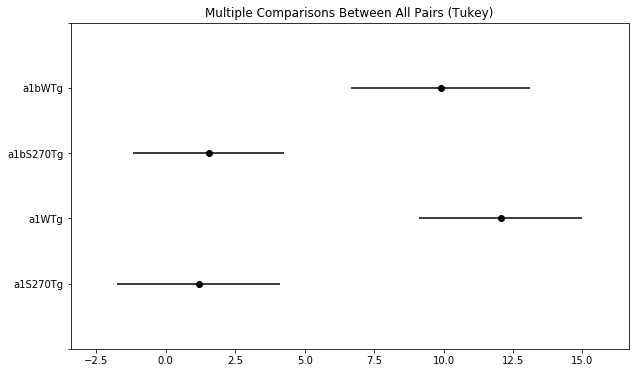

In [48]:
tukey_summary_and_plot(stack_for_tukey(jdeact), jdeact.shape[1])

In [49]:
stop here

SyntaxError: invalid syntax (<ipython-input-49-a96ba3aab008>, line 1)

### Calculate Hedges statistics

In [ ]:
#calculation of hedges d and approximate 95% confidence intervals
#not tested against known values yet AP 170518
hedges_calculation = Hedges_d(T1, T2)
hedges_calculation.hedges_d_unbiased()
#paired needed for degrees of freedom
lowerCI, upperCI = hedges_calculation.bootstrap_CI(5000)
#option to have bootstrap calculated CIs should go here
print(hedges_calculation)

### Run randomisation tests

In [ ]:
nran = 50000
rnt = RantestContinuous(T1, T2, are_paired)    
rnt.run_rantest(nran)
print(rnt)

In [ ]:
fig, ax  = plt.subplots(1,1, figsize=(5,3))
ax.hist(rnt.randiff, 10)
ax.axvline(x=rnt.dbar, color='r')
ax.set_ylabel("Frequency")
ax.set_xlabel('Random difference between means')
print('Red line: mean difference')